## Can mapping the string variables instead of using get_dummies work in this situation?

Let's find out

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
# Read crypto_data.csv into Pandas
crypto_df = pd.read_csv(Path('data/crypto_data.csv'))
crypto_df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


# Data Preparation

In [3]:
# Gather information about dataframe for pre-processing
print('Value Counts of Column IsTrading:')
print(pd.Series(crypto_df['IsTrading']).value_counts())
print('----------')
print('Count of Nulls:')
print(crypto_df.isna().sum())
print('----------')
print('Column Data Types:')
print(crypto_df.dtypes)
print('----------')
print('Shape of Data:')
print(crypto_df.shape)

Value Counts of Column IsTrading:
True     1144
False     108
Name: IsTrading, dtype: int64
----------
Count of Nulls:
Unnamed: 0           0
CoinName             0
Algorithm            0
IsTrading            0
ProofType            0
TotalCoinsMined    508
TotalCoinSupply      0
dtype: int64
----------
Column Data Types:
Unnamed: 0          object
CoinName            object
Algorithm           object
IsTrading             bool
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object
----------
Shape of Data:
(1252, 7)


In [4]:
# Discard all cryptocurrencies that are not being traded and have not been mined
crypto_active = crypto_df[(crypto_df['IsTrading'] == True) & (crypto_df['TotalCoinsMined'] > 0)]

print('Shape of Data:')
crypto_active.shape

Shape of Data:


(532, 7)

In [5]:
# Drop the IsTrading column from the dataframe
crypto_active = crypto_active.drop('IsTrading', axis = 1)

# Remove all rows that have at least one null value
crypto_active = crypto_active.dropna()

print('Shape of Data:')
print(crypto_active.shape)
print('----------')
print('Count of Nulls:')
print(crypto_active.isna().sum())

Shape of Data:
(532, 6)
----------
Count of Nulls:
Unnamed: 0         0
CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64


In [6]:
# Data should be numeric for the machine learning algorithm
# Coin names do not contribute to the analysis of the data so the CoinName column will be dropped, as well as 'Unnamed: 0' as that appears to be the shortened form of the CoinName
crypto_active = crypto_active.drop(['Unnamed: 0', 'CoinName'], axis = 1)
crypto_active.columns

Index(['Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply'], dtype='object')

In [7]:
# Turn "TotalCoinSupply" from object to float64
crypto_active["TotalCoinSupply"] = pd.to_numeric(crypto_active["TotalCoinSupply"])
print(crypto_active.dtypes)

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object


In [8]:
# Analyze column contents of 'Algorithm' and 'ProofType' to determine best way to convert the columns to numerical values
print(pd.Series(crypto_active['Algorithm']).value_counts())
print('----------')
print(pd.Series(crypto_active['ProofType']).value_counts())
print('----------')
print('Shape of Data:')
print(crypto_active.shape)

Scrypt                 182
X11                     73
SHA-256                 48
CryptoNight             19
PoS                     17
                      ... 
HybridScryptHash256      1
Leased POS               1
IMesh                    1
POS 2.0                  1
Tribus                   1
Name: Algorithm, Length: 71, dtype: int64
----------
PoW                     237
PoW/PoS                 176
PoS                      86
DPoS                      9
PoC                       3
PoS/PoW                   2
HPoW                      1
Proof of Trust            1
PoST                      1
PoW + Hive                1
Zero-Knowledge Proof      1
PoS/PoW/PoT               1
TPoS                      1
PoW/PoS                   1
Proof of Authority        1
POBh                      1
dPoW/PoW                  1
LPoS                      1
Pos                       1
PoA                       1
PoW/PoW                   1
PoS/LPoS                  1
PoW/nPoS                  1
DPOS  

In [9]:
# Turn Algorithm and ProofType into numerical columns.
# pd.get_dummies will result in a large number of columns, so a dictionary of values is going to be used to replace the strings
# The number of columns should remain the same

algorithm_list = []

for algorithm in crypto_active['Algorithm']:
    if algorithm not in algorithm_list:
        algorithm_list.append(algorithm)
        
algorithm_dict = {}
for index, algorithm in enumerate(algorithm_list):
    algorithm_dict.update({algorithm: index})
    
    
prooftype_list = []

for prooftype in crypto_active['ProofType']:
    if prooftype not in prooftype_list:
        prooftype_list.append(prooftype)
        
prooftype_dict = {}
for index, prooftype in enumerate(prooftype_list):
    prooftype_dict.update({prooftype: index})
    
crypto_active['Algorithm'] = crypto_active['Algorithm'].map(algorithm_dict)
crypto_active['ProofType'] = crypto_active['ProofType'].map(prooftype_dict) 

print('Shape of Data:')
print(crypto_active.shape)

Shape of Data:
(532, 4)


In [22]:
# Scale the dataset
scaler = StandardScaler().fit(crypto_active)
crypto_scaled = scaler.transform(crypto_active)

# Dimensionality Reduction

### Reduction with Principle Component Analysis (PCA)

In [14]:
# Perform dimensionality reduction with Principle Component Analysis (PCA). Preserve 90% of the explained variance
# Conceptual/Python Explanation: https://vitalflux.com/pca-explained-variance-concept-python-example/
# Visual Explanation: https://setosa.io/ev/principal-component-analysis/

# Initialize PCA model
pca = PCA(n_components=0.90)
crypto_pca = pca.fit_transform(crypto_scaled)

# Observe the change in number of the features
print('Shape of Data after PCA reduction:')
print(crypto_pca.shape)
print(f'After PCA reduction, number of features reduced from {crypto_scaled.shape[1]} to {crypto_pca.shape[1]}.')

Shape of Data after PCA reduction:
(532, 3)
After PCA reduction, number of features reduced from 4 to 3.


### Further Reduction with T-distributed Stochastic Neighbor Embedding (t-SNE)

In [15]:
# Initialize t-SNE model

# learning_rate of 10, 35, 350 , 500, 750, and 1000 tried. All resulted in a reduction to 2 features.
tsne = TSNE(learning_rate = 35)

In [23]:
# Reduce dimensions
crypto_tsne = tsne.fit_transform(crypto_pca)

print('Shape of Data after t-SNE reduction:')
print(crypto_tsne.shape)
print(f'After t-SNE reduction, number of features reduced from {crypto_pca.shape[1]} to {crypto_tsne.shape[1]}.')

Shape of Data after t-SNE reduction:
(532, 2)
After t-SNE reduction, number of features reduced from 3 to 2.


In [24]:
# Create a scatter plot of the t-SNE output

# The first column of transformed features
x_values = crypto_tsne[:,0]

# The second column of transformed features
y_values = crypto_tsne[:,1]

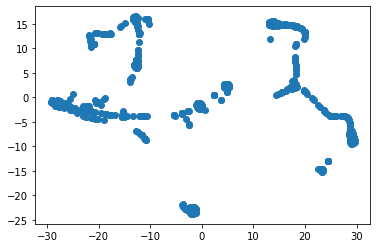

In [25]:
# Visualize the clusters
plt.scatter(x_values, y_values)
plt.show()

There appears to be 4-5 distinct clusters.

# Cluster Analysis with k-Means

In [19]:
# https://en.wikipedia.org/wiki/K-means_clustering

# Use a for-loop to determine the inertia for each k between 1 through 10.

inertia = []
k = list(range(1, 11))

# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_tsne)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

C:\Users\emera\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


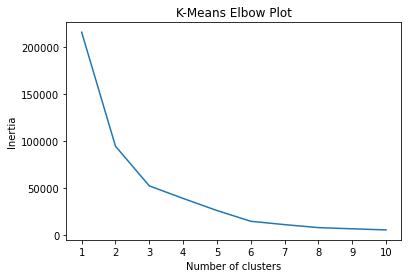

In [20]:
# Create an elbow plot to identify the best number of clusters

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.title("K-Means Elbow Plot")
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The elbow of the plot appears at 6? clusters.

From https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet:
Inertia measures how well a dataset was clustered by K-Means.
It is calculated by measuring the distance between each data point and its centroid,
squaring this distance, and summing these squares across one cluster.

 # Analysis / Recommendation

In [21]:
# Create a report that includes the cryptocurrencies that are on the trading market:
coins_in_trade = crypto_df['CoinName'][(crypto_df['IsTrading'] == True)]
coins_mined_traded = crypto_df['CoinName'][(crypto_df['IsTrading'] == True) & (crypto_df['TotalCoinsMined'] > 0)]

print("The following CryptoCurrencies are being traded, but may not have mined a positive, non-zero amount:\n")
print(coins_in_trade)
print('\n----------\n')
print("The following CryptoCurrencies are being traded, and have mined a positive, non-zero amount:\n")
print(coins_mined_traded)

The following CryptoCurrencies are being traded, but may not have mined a positive, non-zero amount:

0           42 Coin
1           365Coin
2           404Coin
3         SixEleven
4               808
           ...     
1243     Super Zero
1244            UOS
1245         Beldex
1246        Horizen
1247    BitcoinPlus
Name: CoinName, Length: 1144, dtype: object

----------

The following CryptoCurrencies are being traded, and have mined a positive, non-zero amount:

0           42 Coin
2           404Coin
5         EliteCoin
7           Bitcoin
8          Ethereum
           ...     
1238         ZEPHYR
1242        Gapcoin
1245         Beldex
1246        Horizen
1247    BitcoinPlus
Name: CoinName, Length: 532, dtype: object


## Can mapping the string variables instead of using get_dummies work in this situation?

I don't think so. The "clusters" look less like clusters and more like the routes a firefly might take. 